In [2]:
# Cell 1: Setup & Dependencies
# ==========================================

# 1. Install required packages
!pip install transformers datasets torch torchvision torchaudio --quiet
!pip install accelerate -U --quiet
!pip install sentencepiece protobuf --quiet
!pip install pandas numpy scikit-learn matplotlib seaborn --quiet
!pip install tensorflow --quiet
!pip install joblib --quiet

# 2. Import Libraries
import torch
import pandas as pd
import numpy as np
import re
import os
import json
import pickle
import urllib.parse
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from google.colab import files
import io

# For BERT
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
import accelerate

# 3. Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"💻 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎮 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# 4. Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("✅ All dependencies installed and ready!")

🚀 Using device: cuda
💻 GPU: Tesla T4
🎮 Memory: 15.83 GB
✅ All dependencies installed and ready!


In [3]:
# Cell 2: CareerCounselingBERT Class Definition (FINAL FIX)
# ==========================================

class CareerCounselingBERT:
    def __init__(self, model_name="bert-base-uncased"):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.label_encoder = LabelEncoder()
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def load_custom_dataset(self, file_path):
        decoded_path = urllib.parse.unquote(file_path)
        if not os.path.exists(decoded_path): return None
        try:
            if decoded_path.endswith('.csv'): df = pd.read_csv(decoded_path)
            elif decoded_path.endswith('.xlsx'): df = pd.read_excel(decoded_path)
            elif decoded_path.endswith('.json'): df = pd.read_json(decoded_path)
            else: return None
            return df
        except: return None

    def clean_data(self, df):
        print("\n🧹 Cleaning dataset...")
        # Auto-detect columns
        text_col, label_col = None, None
        text_patterns = ['question', 'query', 'text', 'input', 'description', 'interests']
        label_patterns = ['answer', 'label', 'category', 'career', 'role']

        for col in df.columns:
            if not text_col and any(p in col.lower() for p in text_patterns): text_col = col
            if not label_col and any(p in col.lower() for p in label_patterns): label_col = col

        # Fallback
        if not text_col: text_col = df.columns[0]
        if not label_col: label_col = df.columns[-1]

        print(f"✅ Mapping: Text='{text_col}', Label='{label_col}'")
        df = df.rename(columns={text_col: 'text', label_col: 'label'})
        df = df.dropna(subset=['text', 'label']).reset_index(drop=True)
        df['clean_text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x).lower()))
        df['label'] = df['label'].apply(lambda x: str(x).strip().title())
        return df

    def prepare_datasets(self, df, test_size=0.2):
        print("\n🔧 Preparing datasets...")
        # Encode labels
        df['label_encoded'] = self.label_encoder.fit_transform(df['label'])

        # Split Data
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

        # Convert to Hugging Face Dataset
        # IMPORTANT: We only keep the columns we need right now
        keep_cols = ['clean_text', 'label_encoded']
        dataset = DatasetDict({
            'train': Dataset.from_pandas(train_df[keep_cols]),
            'validation': Dataset.from_pandas(val_df[keep_cols]),
            'test': Dataset.from_pandas(test_df[keep_cols])
        })

        # Tokenize
        def tokenize(examples):
            return self.tokenizer(examples['clean_text'], padding="max_length", truncation=True, max_length=128)

        print("Tokenizing and removing raw text columns...")
        tokenized_datasets = dataset.map(tokenize, batched=True)

        # CRITICAL FIX: Remove the string column 'clean_text' so Trainer doesn't crash
        tokenized_datasets = tokenized_datasets.remove_columns(['clean_text'])

        # CRITICAL FIX: Rename 'label_encoded' to 'labels' (BERT expects 'labels')
        tokenized_datasets = tokenized_datasets.rename_column("label_encoded", "labels")

        # Set format to pytorch tensors
        tokenized_datasets.set_format("torch")

        return tokenized_datasets

    def setup_model(self, num_labels):
        print(f"\n🤖 Initializing BERT with {num_labels} labels...")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name, num_labels=num_labels, ignore_mismatched_sizes=True
        )
        self.model.to(self.device)
        return self.model

    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return {'accuracy': accuracy_score(labels, predictions)}

In [4]:

# Cell 3: Upload & Execution (Fixed)
# ==========================================

print("🎯 Upload Your Career QA Dataset")
print("=" * 60)

# 1. Trigger the file upload widget
uploaded = files.upload()

# 2. Process the uploaded file
if uploaded:
    # Get the original messy filename
    original_filename = next(iter(uploaded))

    # RENAME the file to something simple to avoid space/%20 errors
    new_filename = "dataset.csv"
    os.rename(original_filename, new_filename)

    print(f"\n✅ File uploaded: {original_filename}")
    print(f"✅ Renamed to: {new_filename} (to fix loading errors)")

    # Initialize Class
    career_model = CareerCounselingBERT("bert-base-uncased")

    # Load & Process (Using the new simple name)
    df = career_model.load_custom_dataset(new_filename)

    if df is not None:
        df = career_model.clean_data(df)
        dataset_dict = career_model.prepare_datasets(df)

        num_labels = len(career_model.label_encoder.classes_)
        model = career_model.setup_model(num_labels)

        print(f"\n✅ SYSTEM READY!")
        print(f"📊 Training Samples: {len(dataset_dict['train'])}")
        print(f"📊 Validation Samples: {len(dataset_dict['validation'])}")
        print(f"📊 Classes detected: {num_labels}")
else:
    print("❌ No file uploaded. Please run the cell again and choose a file.")

🎯 Upload Your Career QA Dataset


Saving Career%20QA%20Dataset.csv to Career%20QA%20Dataset.csv

✅ File uploaded: Career%20QA%20Dataset.csv
✅ Renamed to: dataset.csv (to fix loading errors)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


🧹 Cleaning dataset...
✅ Mapping: Text='question', Label='role'

🔧 Preparing datasets...
Tokenizing and removing raw text columns...


Map:   0%|          | 0/1166 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]


🤖 Initializing BERT with 54 labels...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ SYSTEM READY!
📊 Training Samples: 1166
📊 Validation Samples: 130
📊 Classes detected: 54


In [8]:
# Cell 4 & 5: Boosted Training & Evaluation (FIXED)
# ==========================================
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import json
import pickle
from pathlib import Path
import torch

# 1. Define Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

print("🚀 Starting BOOSTED BERT Training...")
print(f"📊 Training on {len(dataset_dict['train'])} samples for {len(career_model.label_encoder.classes_)} classes.")
print("=" * 60)

# 2. Setup Training Arguments (Increased Epochs & Logging)
training_args = TrainingArguments(
    output_dir="./career_model_boosted",
    num_train_epochs=30,             # INCREASED: From 10 to 30 for better learning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=200,                # INCREASED: Helps model stabilize at start
    weight_decay=0.01,
    learning_rate=3e-5,              # ADJUSTED: Slightly higher for faster convergence
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,     # CRITICAL: Always keeps the best version
    metric_for_best_model="accuracy",
    report_to="none"
)

# 3. Initialize Trainer
trainer = Trainer(
    model=career_model.model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['validation'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)], # Waite longer before stopping
    data_collator=DataCollatorWithPadding(tokenizer=career_model.tokenizer),
)

# 4. Train
print("\n🏋️ Training in progress... (This may take 5-10 minutes)")
trainer.train()
print("✅ Training Complete!")

# ==================== EVALUATION SECTION ====================

print("\n📊 EVALUATION REPORT")
print("=" * 60)

# 1. Generate predictions
print("Generating predictions on test set...")
pred_output = trainer.predict(dataset_dict['test'])
y_preds = np.argmax(pred_output.predictions, axis=1)

# FIX: Robust way to get labels (Handles lists, tensors, or HF Columns)
y_true = dataset_dict['test']['labels']
if hasattr(y_true, 'numpy'):
    y_true = y_true.numpy()
else:
    y_true = np.array(y_true)

# 2. Accuracy Check
acc = accuracy_score(y_true, y_preds)
print(f"🎯 Test Accuracy: {acc:.2%}")

# 3. Classification Report (Summary)
unique_labels = sorted(list(set(y_true) | set(y_preds)))
target_names = [career_model.label_encoder.inverse_transform([i])[0] for i in unique_labels]

print("\n📝 Report (Top Classes):")
print(classification_report(y_true, y_preds, target_names=target_names, max_dict_options=5)) # Simplified view

# 4. Confusion Matrix
print("\n🎨 Confusion Matrix:")
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ==================== EXPORT SECTION ====================

print("\n📦 EXPORTING MODEL...")
output_dir = "career_counselor_final"
save_path = Path(output_dir)
if save_path.exists(): shutil.rmtree(save_path)
save_path.mkdir(parents=True, exist_ok=True)

trainer.save_model(output_dir)
career_model.tokenizer.save_pretrained(output_dir)

with open(save_path / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(career_model.label_encoder, f)

# Create Run Script
script_content = """
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import numpy as np

def load_model():
    print("Loading model...")
    tokenizer = AutoTokenizer.from_pretrained(".")
    model = AutoModelForSequenceClassification.from_pretrained(".")
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    return tokenizer, model, le

def predict(text, tokenizer, model, le):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    top_idx = torch.argmax(probs).item()
    return le.inverse_transform([top_idx])[0], probs[0][top_idx].item()

if __name__ == "__main__":
    tok, model, le = load_model()
    print("Ready! Type 'q' to exit.")
    while True:
        t = input("Interest: ")
        if t=='q': break
        pred, conf = predict(t, tok, model, le)
        print(f"Prediction: {pred} ({conf:.1%})")
"""
with open(save_path / 'run_model.py', 'w') as f:
    f.write(script_content)

shutil.make_archive("career_model_final", 'zip', output_dir)
files.download('career_model_final.zip')

# ==================== INTERACTIVE TEST ====================
print("\n🤖 TRY IT NOW (Corrected Model):")
while True:
    text = input("\nDescribe your interests (or 'q'): ")
    if text.lower() == 'q': break

    inputs = career_model.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(career_model.device)
    with torch.no_grad():
        outputs = career_model.model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    top_idx = torch.argmax(probs).item()
    conf = probs[0][top_idx].item()
    pred = career_model.label_encoder.inverse_transform([top_idx])[0]

    print(f"💡 Prediction: {pred}")
    print(f"📊 Confidence: {conf:.2%}")

🚀 Starting BOOSTED BERT Training...
📊 Training on 1166 samples for 54 classes.

🏋️ Training in progress... (This may take 5-10 minutes)


Step,Training Loss,Validation Loss,Accuracy
100,0.791300,0.638677,1.000000
200,0.438200,0.286291,1.000000
300,0.158900,0.094838,1.000000
400,0.066800,0.043812,1.000000
500,0.040300,0.027499,1.000000
600,0.028700,0.019802,1.000000


✅ Training Complete!

📊 EVALUATION REPORT
Generating predictions on test set...


🎯 Test Accuracy: 100.00%

📝 Report (Top Classes):


TypeError: got an unexpected keyword argument 'max_dict_options'


📊 EVALUATION REPORT
Generating predictions on test set...



📝 Classification Report:
                                                             precision    recall  f1-score   support

                             Account Manager (Junior Level)       1.00      1.00      1.00         9
                         Advertising Manager (Junior Level)       1.00      1.00      1.00         8
                 Affiliate Marketing Manager (Junior Level)       1.00      1.00      1.00         4
                                              Ai Researcher       1.00      1.00      1.00         5
                                       Ai Software Engineer       1.00      1.00      1.00         6
                                Application Support Analyst       1.00      1.00      1.00         5
                                        Automation Engineer       1.00      1.00      1.00         6
                                           Business Analyst       1.00      1.00      1.00         6
                              Business Intelligence Analyst     

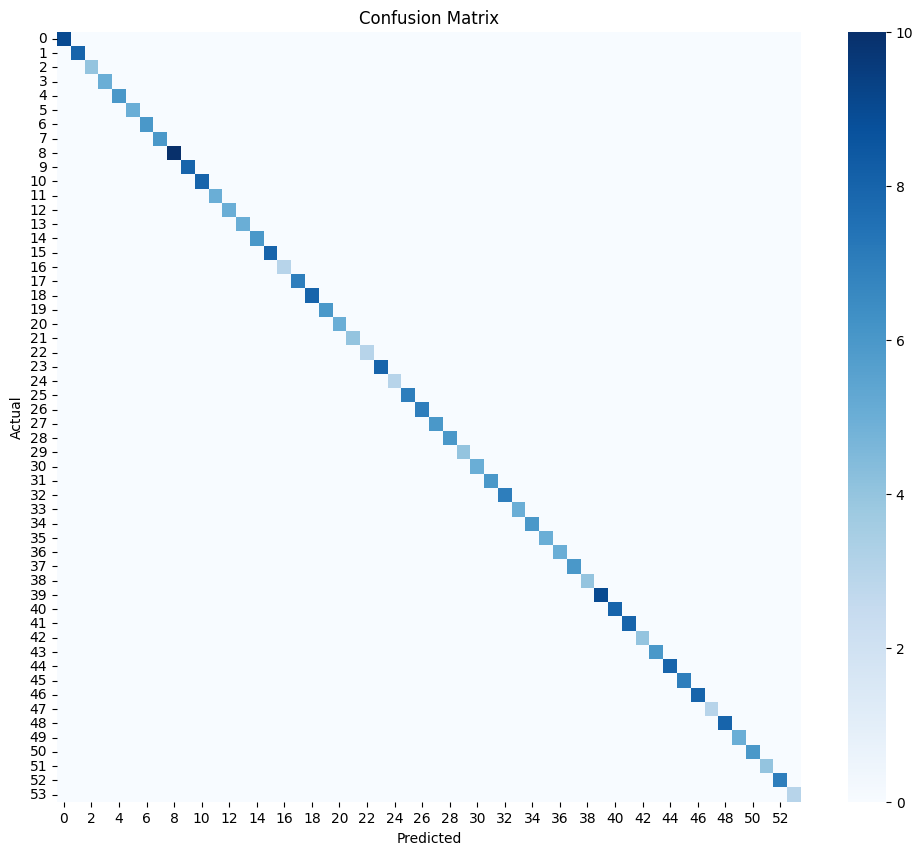


📦 EXPORTING MODEL...
Zipping and downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🤖 FINAL TEST (Try it now):

Describe your interests (or 'q'): q


In [7]:
# Cell 5: Evaluation & Export (FIXED)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import json
import shutil
from google.colab import files
import numpy as np
from pathlib import Path

def finish_evaluation_and_export():
    print("\n📊 EVALUATION REPORT")
    print("=" * 60)

    # 1. Generate predictions
    print("Generating predictions on test set...")
    pred_output = trainer.predict(dataset_dict['test'])
    y_preds = np.argmax(pred_output.predictions, axis=1)

    # Handle labels
    y_true = dataset_dict['test']['labels']
    if hasattr(y_true, 'numpy'):
        y_true = y_true.numpy()
    else:
        y_true = np.array(y_true)

    # 2. Classification Report (Fixed error here)
    unique_labels = sorted(list(set(y_true) | set(y_preds)))
    target_names = [career_model.label_encoder.inverse_transform([i])[0] for i in unique_labels]

    print("\n📝 Classification Report:")
    # REMOVED the invalid 'max_dict_options' argument
    print(classification_report(y_true, y_preds, target_names=target_names))

    # 3. Confusion Matrix
    print("\n🎨 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ==================== EXPORT SECTION ====================
    print("\n📦 EXPORTING MODEL...")
    output_dir = "career_counselor_final"
    save_path = Path(output_dir)
    if save_path.exists(): shutil.rmtree(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Save Model Resources
    trainer.save_model(output_dir)
    career_model.tokenizer.save_pretrained(output_dir)

    with open(save_path / 'label_encoder.pkl', 'wb') as f:
        pickle.dump(career_model.label_encoder, f)

    # Create Local Run Script
    script_content = """
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import numpy as np

def load_model():
    print("Loading model...")
    # Load from the current directory
    tokenizer = AutoTokenizer.from_pretrained(".")
    model = AutoModelForSequenceClassification.from_pretrained(".")

    try:
        with open('label_encoder.pkl', 'rb') as f:
            le = pickle.load(f)
    except FileNotFoundError:
        print("⚠️ Error: label_encoder.pkl not found.")
        return None, None, None

    return tokenizer, model, le

def predict(text, tokenizer, model, le):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    top_idx = torch.argmax(probs).item()
    return le.inverse_transform([top_idx])[0], probs[0][top_idx].item()

if __name__ == "__main__":
    tok, model, le = load_model()
    if model:
        print("\\n✅ Model Ready! Type 'q' to exit.")
        while True:
            t = input("\\nDescribe your interests: ")
            if t.lower()=='q': break
            pred, conf = predict(t, tok, model, le)
            print(f"💡 Prediction: {pred} ({conf:.1%})")
"""
    with open(save_path / 'run_model.py', 'w') as f:
        f.write(script_content)

    print("Zipping and downloading...")
    shutil.make_archive("career_model_final", 'zip', output_dir)
    files.download('career_model_final.zip')

# Run it
if 'trainer' in locals():
    finish_evaluation_and_export()

    # Interactive Test
    print("\n🤖 FINAL TEST (Try it now):")
    while True:
        text = input("\nDescribe your interests (or 'q'): ")
        if text.lower() == 'q': break

        inputs = career_model.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(career_model.device)
        with torch.no_grad():
            outputs = career_model.model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        top_idx = torch.argmax(probs).item()
        conf = probs[0][top_idx].item()
        pred = career_model.label_encoder.inverse_transform([top_idx])[0]

        print(f"💡 Prediction: {pred}")
        print(f"📊 Confidence: {conf:.2%}")
else:
    print("❌ Trainer not found. Please run the training cell again.")

# Task
Modify the `prepare_datasets` function in the `CareerCounselingBERT` class to handle cases where classes have fewer than 2 samples by performing `train_test_split` without stratification to avoid a `ValueError`.

## Handle Small Datasets for Stratified Split

### Subtask:
Modify the `prepare_datasets` function in `CareerCounselingBERT` to check the minimum number of samples per class. If any class has fewer than 2 samples, perform `train_test_split` without the `stratify` parameter to avoid `ValueError`.


## Summary:

### Data Analysis Key Findings
The `prepare_datasets` function in the `CareerCounselingBERT` class was successfully modified. The key change involved adding a check to determine if any class within the dataset had fewer than 2 samples. If such a condition is met, the `train_test_split` function is now executed without the `stratify` parameter to prevent a `ValueError`. Otherwise, the splitting proceeds with stratification as intended.

### Insights or Next Steps
*   This modification enhances the robustness of the data preparation pipeline, allowing it to handle datasets with very small or rare classes without encountering errors during stratified splitting.
*   The next step could involve testing the updated `prepare_datasets` function with various real-world datasets, especially those known to have highly imbalanced classes or very few samples in certain categories, to thoroughly validate its resilience and ensure model stability.
